In [28]:
from tqdm import tqdm
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import itertools
import ipywidgets as widgets
from IPython.display import display

In [29]:
np.random.seed(1)

# Distribution parameters
mean_a, std_a = 0.5, 1
mean_b, std_b = 0.0, 1

# Domain of alpha values to test
# Testing num values of (alpha_min - alpha_max) / num
alpha_min, alpha_max = 0.01, 1
alphas = np.linspace(alpha_min, alpha_max, num=100)
print("Alphas:", alphas)

# Sample size of each distribution
n = 75 

# Generate samples from normal distributions
a = np.random.normal(mean_a, std_a, n)
b = np.random.normal(mean_b, std_b, n)

#Step Parameters
# U+ / U- > C+ / C-
u_plus = 1
u_minus = -1.1
c_plus = 1
c_minus = -c_plus
range = (-3, 3)
interval = 0.1

Alphas: [0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7
 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84
 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.99 1.  ]


In [ ]:
from utils import opt_threshold, alt_fair_opt_step

# Store results
x_alphas = []
y_mean_A = []
y_mean_B = []
y_thresh_A = []
y_thresh_B = []
y_util = []

y6 = opt_threshold((-3, 3), u_plus=1, u_minus=-1)

for alpha in tqdm(alphas):
    results = alt_fair_opt_step(a, b, u_plus, u_minus, c_plus, c_minus, alpha, range, interval)
    if results[0] is not None and results[1] is not None:
        A, B, thresh_A, thresh_B, max_util = results
        x_alphas.append(alpha)
        
        y_mean_A.append(np.mean(A))
        y_mean_B.append(np.mean(B))
        y_thresh_A.append(thresh_A)
        y_thresh_B.append(thresh_B)
        y_util.append(max_util) 

100%|██████████| 100/100 [00:00<00:00, 133.22it/s]


In [ ]:
def plot_fairness(show_means=True, show_fair_thresholds=True, show_opt_thresholds=True, show_utility=True):
    plt.figure(figsize=(10, 6))

    if show_means:
        plt.plot(0, mean_a, 'ro', label='Initial μ(A)')
        plt.plot(0, mean_b, 'bo', label='Initial μ(B)')
        plt.plot(x_alphas, y_mean_A, label="Fair μ(A)'", color='red')
        plt.plot(x_alphas, y_mean_B, label="Fair μ(B)'", color='blue') 

    if show_fair_thresholds:
        plt.scatter(x_alphas, y_thresh_A, label="Fair Threshold (A)", color='orange')
        plt.scatter(x_alphas, y_thresh_B, label="Fair Threshold (B)", color='purple')
    
    if show_opt_thresholds:
        plt.axhline(y6, color='purple', linestyle='--', label='Optimal Threshold')

    if show_utility:
        plt.plot(x_alphas, y_util, label='Total Utility', color='green')

    plt.title("Fair vs. Optimal Means under Varying Fairness Constraint α")
    plt.xlabel("α (Fairness Threshold)")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Toggle widgets
means_toggle = widgets.Checkbox(value=True, description='Show Means')
fair_thresholds_toggle = widgets.Checkbox(value=True, description='Show Fair Thresholds')
opt_thresholds_toggle = widgets.Checkbox(value=True, description='Show Optimal Threshold')
utility_toggle = widgets.Checkbox(value=True, description='Show Utility')

ui = widgets.HBox([means_toggle, fair_thresholds_toggle, opt_thresholds_toggle, utility_toggle])
out = widgets.interactive_output(plot_fairness, {
    'show_means': means_toggle,
    'show_fair_thresholds': fair_thresholds_toggle,
    'show_opt_thresholds': opt_thresholds_toggle,
    'show_utility': utility_toggle,
})

display(ui, out)

Output()

In [8]:
print(y6)
results = alt_fair_opt_step(pop_A=a, pop_B=b, u_plus=1, u_minus=-1, c_plus=1, c_minus=-1, alpha=0.5, range_param=(-3, 3), size=0.01)
from utils import alt_fair_step
l = alt_fair_step(a, b, 1, -1, 1, -1, 0.5, (-3, 3), 0.01)

print(np.sum(results[0] + results[1]))
print(np.sum(l[0] + l[1]))


-4.440892098500626e-16
73.69532793297168
73.69532793297168


Text(0.5, 1.0, 'Threshold A with Fixed Threshold B vs Total Utility')

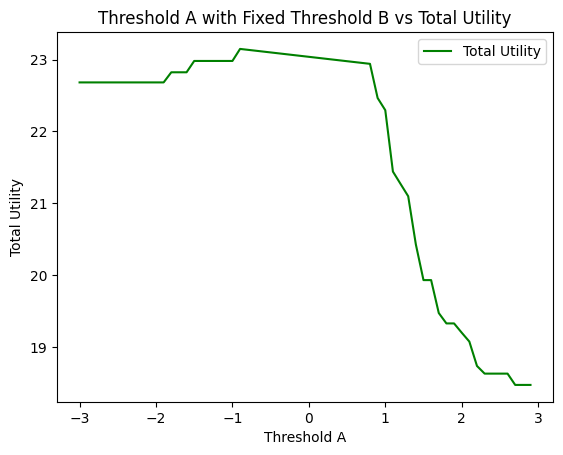

In [51]:
### Experiment where alpha and the threshold of B is fixed while we vary the threshold of A

x_thresh_A = []
thresh_B = y_thresh_B[-1]
y_means_diff = []

from utils import expected
delta_A = expected(a, c_plus, c_minus)
delta_B = expected(b, c_plus, c_minus)

B = np.where(b > thresh_B, b + delta_B, b)
util_B = np.sum(expected(B, u_plus, u_minus))
util_A = []

thresholds = np.arange(range[0], range[1], interval)
for threshold in thresholds:
    alpha = 0.57
    A = np.where(a > threshold, a + delta_A, a)
    diff = np.abs(np.mean(A) - np.mean(B))
    y_means_diff.append(diff)
    utility = np.sum(expected(A, u_plus, u_minus))
    util_A.append(utility)
    x_thresh_A.append(threshold)

y_means_diff = np.array(y_means_diff)
x_thresh_A = np.array(x_thresh_A)

index = np.where(y_means_diff < alpha)[0]
x_util_thresh_A = x_thresh_A[index]
total_util = np.array(util_A) + util_B
total_util = total_util[index]

plt.plot(x_util_thresh_A, total_util, label='Total Utility', color='green')
plt.legend()
plt.xlabel("Threshold A")
plt.ylabel("Total Utility")
plt.title("Threshold A with Fixed Threshold B vs Total Utility")


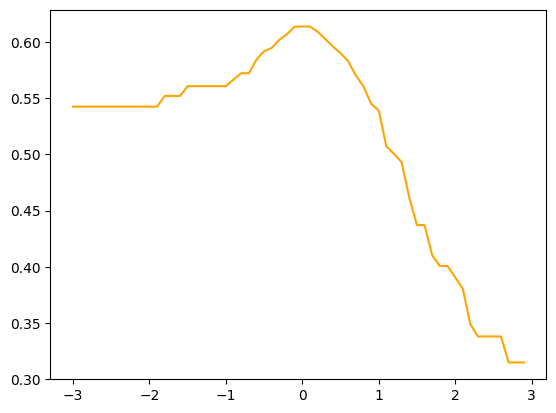

In [52]:
### Experiment where the threshold of B is fixed while we track the difference in means of A and B
plt.plot(x_thresh_A, y_means_diff, label='Mean Difference', color='orange')

